## 1. Fundamental frequency estimation by eye

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 5)

### a) Load

In [8]:
s1, sampling_freq_1 = librosa.core.load("speech1.wav", sr=None)
s2, sampling_freq_2 = librosa.core.load("speech2.wav", sr=None)

In [9]:
s1.shape, s2.shape, sampling_freq_1, sampling_freq_2

((45466,), (45773,), 16000, 16000)

The sampling frequency is 16 000 Hz

In [10]:
sampling_freq = 16000

### b) Plot

In [11]:
def plot_signal(signal, sampling_freq, title):
    time = np.arange(signal.shape[0]) / sampling_freq
    plt.plot(time, signal)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.show()

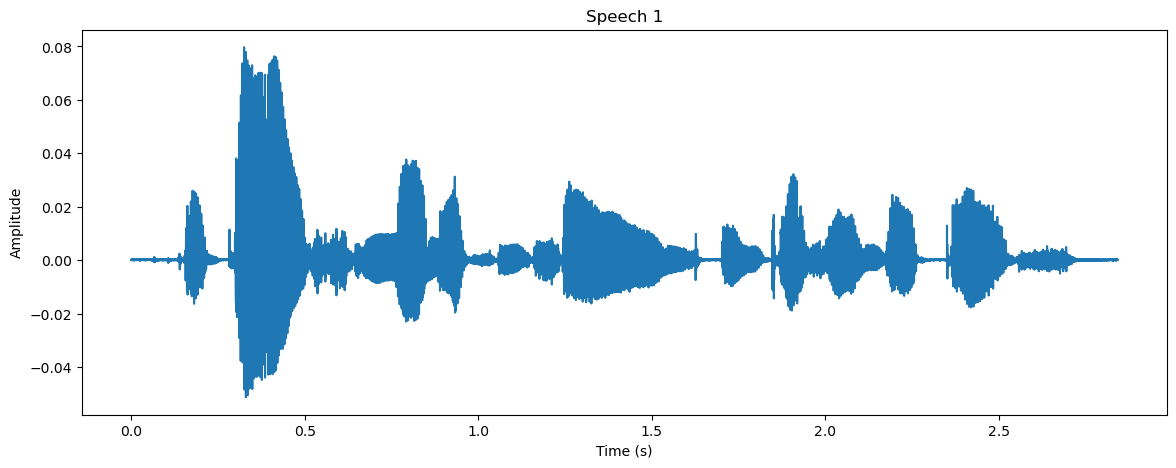

In [12]:
plot_signal(s1, sampling_freq, "Speech 1")

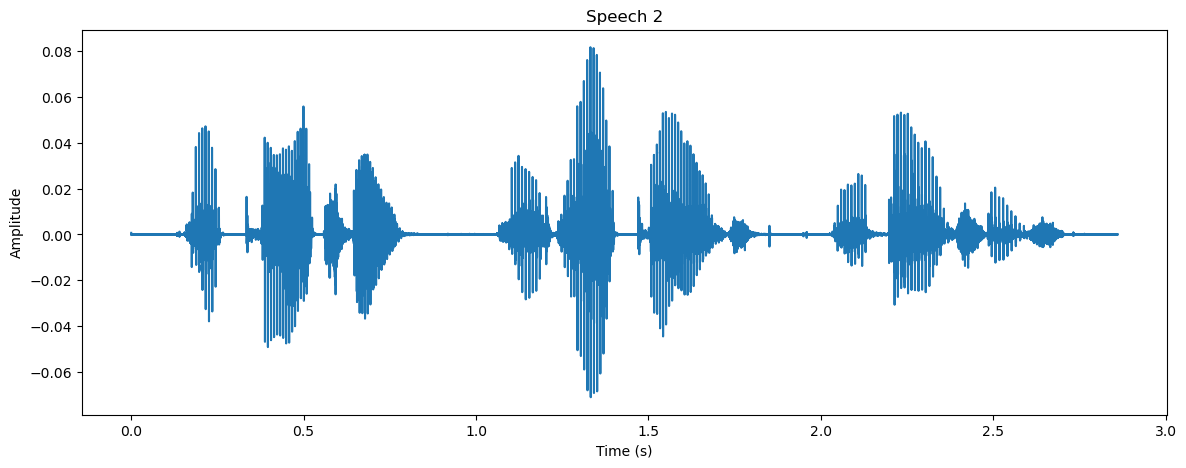

In [13]:
plot_signal(s2, sampling_freq, "Speech 2")

Silence corresponds to the parts with amplitude near zero.

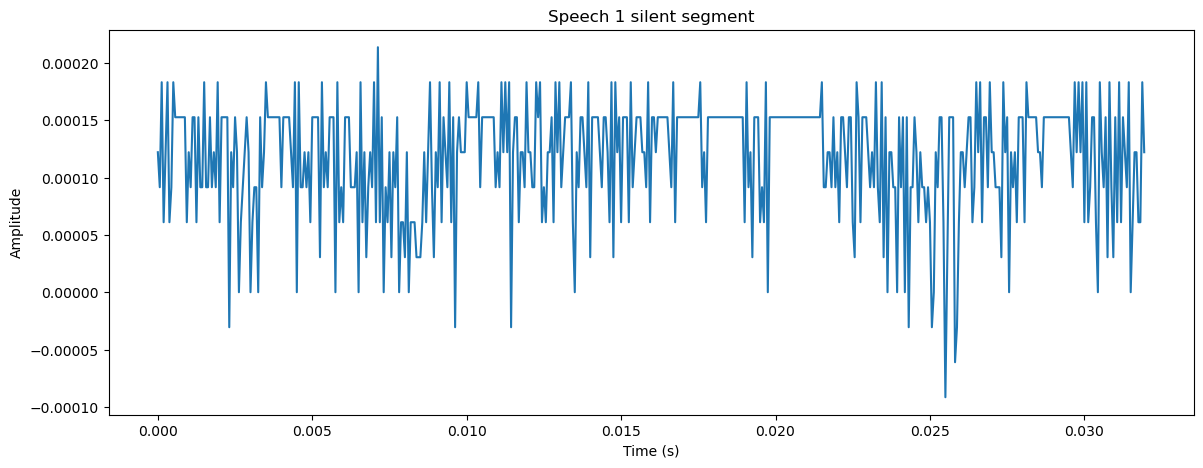

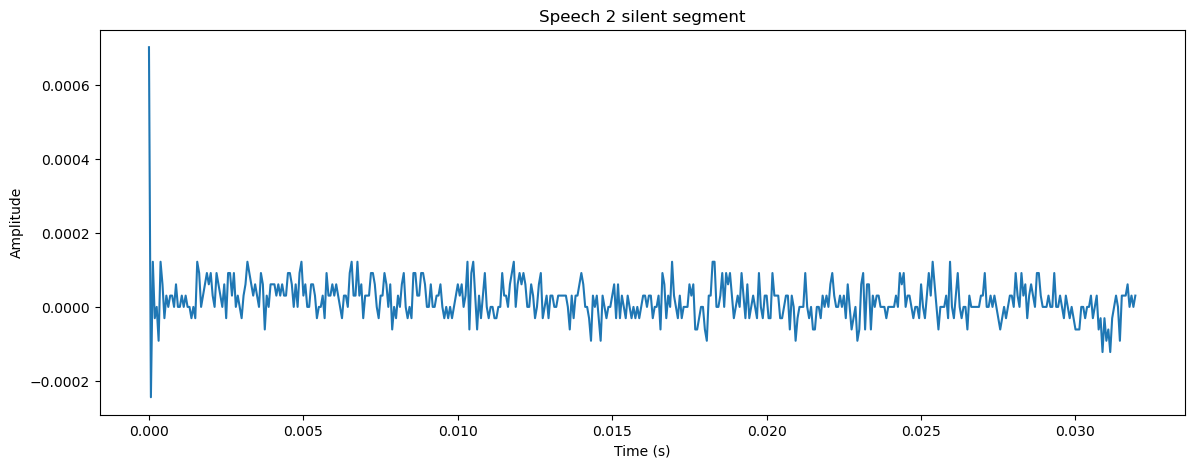

In [21]:
s1_seg_silent = s1[0:512]
s2_seg_silent = s2[0:512]
plot_signal(s1_seg_silent, sampling_freq, "Speech 1 silent segment")
plot_signal(s2_seg_silent, sampling_freq, "Speech 2 silent segment")

Unvoiced region: a region where the amplitudes are not close to zero, and where we can see no periodic trend

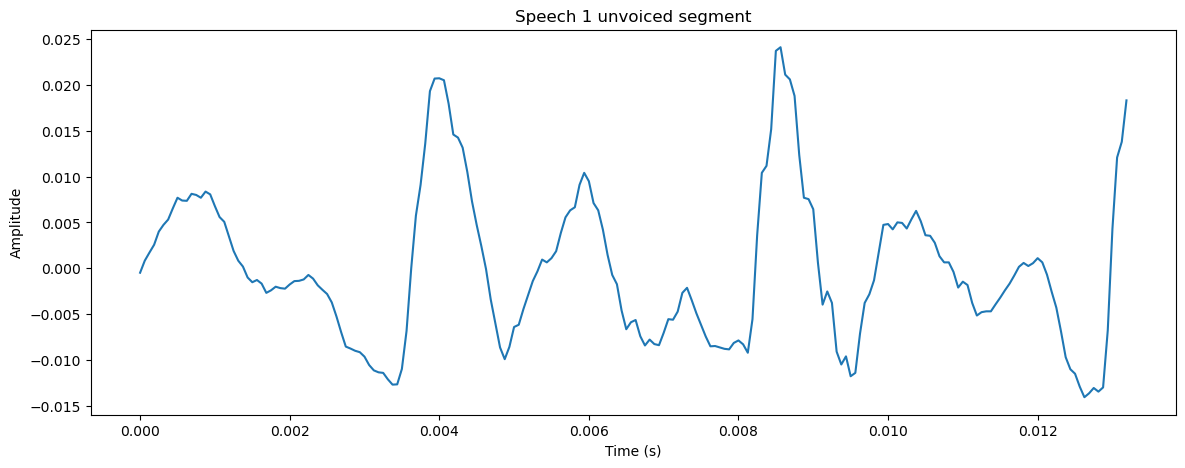

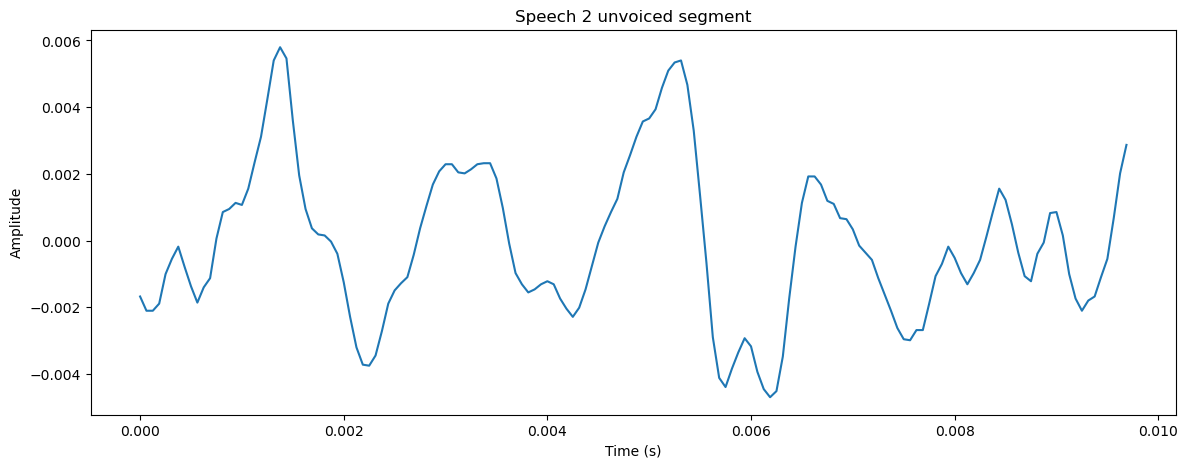

In [20]:
s1_seg_unvoiced = s1[19900:20112]
s2_seg_unvoiced = s2[19800:19956]
plot_signal(s1_seg_unvoiced, sampling_freq, "Speech 1 unvoiced segment")
plot_signal(s2_seg_unvoiced, sampling_freq, "Speech 2 unvoiced segment")

### c) Fundamental frequency estimation

In [8]:
# select a voiced segment from both signals
s1_seg = s1[5200:5500]
s2_seg = s2[24800:25100]

Voiced region: a region where the amplitudes are not close to zero, and also we can see a periodic trend

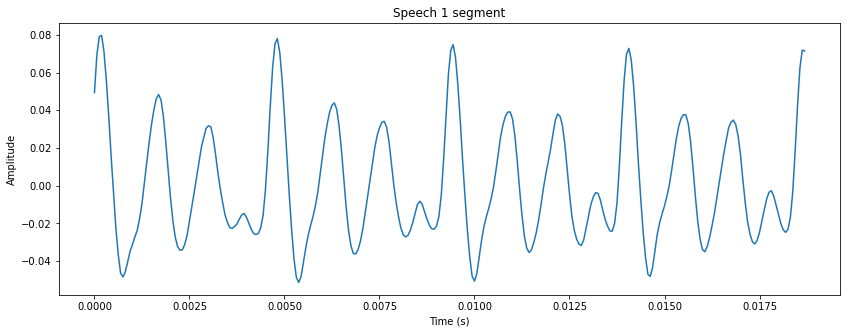

In [9]:
plot_signal(s1_seg, sampling_freq, "Speech 1 voiced segment")

In [10]:
print(f"Fundamental freq of signal 1: {1 / (0.01 - 0.005)}")

Fundamental freq of signal 1: 200.0


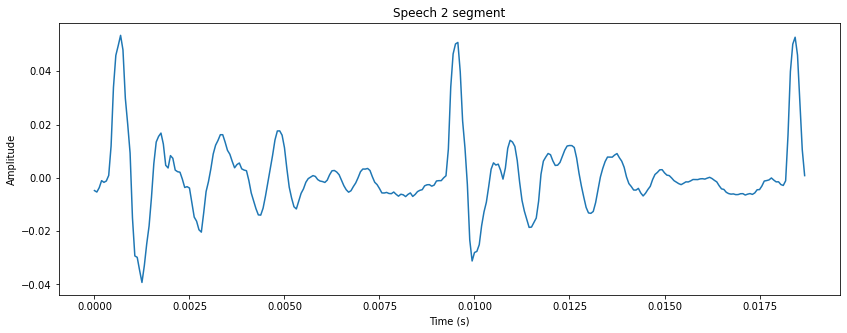

In [11]:
plot_signal(s2_seg, sampling_freq, "Speech 2 voiced segment")

In [12]:
print(f"Fundamental freq of signal 1: {1 / (0.01 - 0.0005)}")

Fundamental freq of signal 1: 105.26315789473685


The fundamental frequency of signal 1 is about 200 Hz, and the fundamental frequency of signal 2 is about 100 Hz. This suggests that signal 1 belongs to a female speaker, while signal 2 is from a male speaker.

## 2) Block processing

In [13]:
def my_windowing(
    v_signal: np.ndarray,
    sampling_rate: int,
    frame_length: int,
    frame_shift: int = None,
) -> tuple[np.ndarray, np.ndarray]:
    if frame_shift is None:
        frame_shift = frame_length

    frame_len_samples = np.floor(frame_length * sampling_rate / 1000).astype(int)
    frame_shift_samples = np.floor(frame_shift * sampling_rate / 1000).astype(int)
    m_frames = []
    frame_centers = []
    for i in range(0, len(v_signal) - frame_len_samples, frame_shift_samples):
        m_frames.append(v_signal[i : i + frame_len_samples])
        frame_centers.append((i + frame_len_samples // 2) * 1000 / sampling_rate)
    return np.array(m_frames), np.array(frame_centers)

The signal can be split into $ \left \lfloor \frac{ \text{signal_length} - \text{frame_length} }{\text{frame_shift}} + 1 \right \rfloor $ frames

## 3) Fundamental frequency estimator

### a) Split into frames

In [14]:
FRAME_LEN = 32
FRAME_SHIFT = 16

frames, frame_centers = my_windowing(s1, sampling_freq, FRAME_LEN, FRAME_SHIFT)
len(frames)

176

### b) Autocorrelation as convolution & c) Remove negative lag

In [15]:
def acf(frames):
    # convolve each frame with its time-reversed version
    acf_frames = [np.convolve(frame, frame[::-1]) for frame in frames]
    acf_frames = np.array(acf_frames)
    acf_frames = acf_frames[:, acf_frames.shape[1] // 2 :]
    return acf_frames

acf_frames = acf(frames)
acf_frames.shape

(176, 512)

### d) Estimate f0

In [16]:
def estimate_fundamental_frequency(
    acf_frames: np.ndarray,
    sampling_freq: int,
    min_freq: float = 80,
    max_freq: float = 400,
) -> np.ndarray:
    """
    Estimate the fundamental frequency of each frame in acf_frames by searching
    for the maximum.
    """
    # convert bounds to acf indices
    min_lag = int(sampling_freq / max_freq)
    max_lag = int(sampling_freq / min_freq)
    f0s = np.argmax(acf_frames[:, min_lag:max_lag], axis=1) + min_lag
    return sampling_freq / f0s

In [17]:
MIN_FREQ = 80
MAX_FREQ = 400

fundamental_freqs = estimate_fundamental_frequency(
    acf_frames,
    sampling_freq,
    min_freq=MIN_FREQ,
    max_freq=MAX_FREQ,
)
fundamental_freqs.shape


(176,)

### e) Plot signal and estimated fundamental frequencies

In [18]:
def plot_signal_and_f0(signal: np.ndarray, title: str):
    frames, frame_centers = my_windowing(
        signal,
        sampling_freq,
        FRAME_LEN,
        FRAME_SHIFT,
    )
    acf_frames = acf(frames)
    fundamental_freqs = estimate_fundamental_frequency(
        acf_frames,
        sampling_freq,
        min_freq=MIN_FREQ,
        max_freq=MAX_FREQ,
    )

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(13, 6))
    fig.align_ylabels()

    time = np.arange(signal.shape[0]) / sampling_freq * 1000 # in ms
    ax1.plot(time, signal)
    ax1.set_ylabel("Amplitude")

    ax2.plot(frame_centers, fundamental_freqs)
    ax2.set_xlabel("Time (ms)")
    ax2.set_ylabel("Fundamental frequency (Hz)")

    # BONUS: detect smooth regions and estimate the fundamental frequency
    # smooth ~= low gradient (approx. as finite difference)
    diff = np.diff(fundamental_freqs, prepend=fundamental_freqs[0])
    smooth = np.abs(diff) < 10
    # only keep contigious regions of sufficient length
    min_len_smooth = 3 # in frames
    smooth = np.convolve(smooth, np.ones(min_len_smooth), mode="same") >= min_len_smooth
    est_f0 = np.mean(fundamental_freqs[smooth])
    ax2.plot(frame_centers[smooth], fundamental_freqs[smooth], "o", color="red", label="Voiced region estimate")
    ax2.legend()

    fig.suptitle(title + f"\nEstimated f0: {est_f0:.2f} Hz")

    plt.tight_layout()
    plt.show()

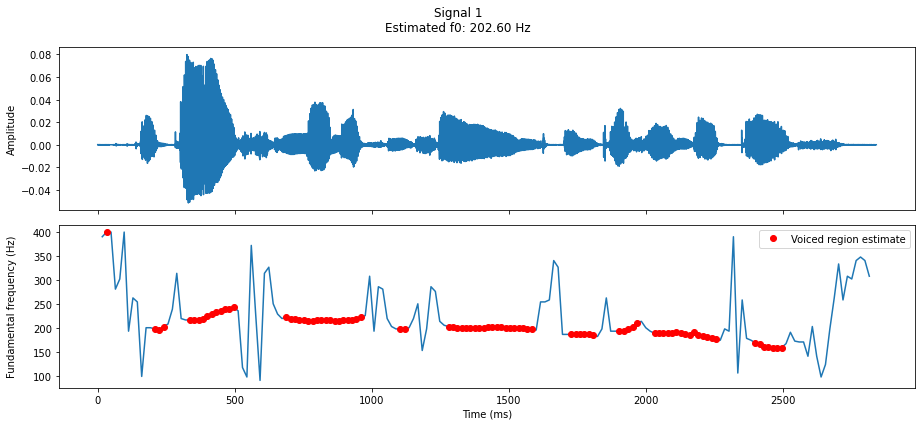

In [19]:
plot_signal_and_f0(s1, "Signal 1")

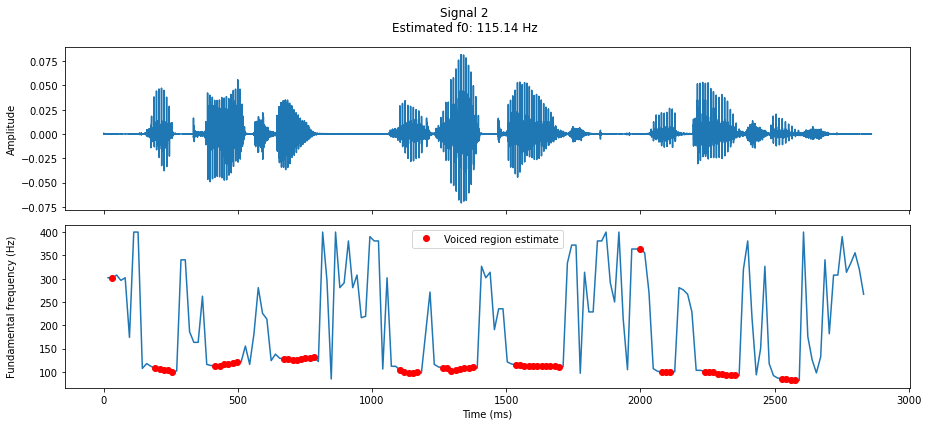

In [20]:
plot_signal_and_f0(s2, "Signal 2")

We can see that the fundamental frequency estimator provides **smooth** estimates for voiced regions, while the estimated fundamental frequency is **noisy** for unvoiced or silent regions. We have implemented simple smooth region detection (plotted in red) to estimate the fundamental frequency of speakers.

Moreover, the estimated fundamental frequency for voiced regions hovers around 200 Hz for the 1st signal, and around 100 Hz for the 2nd signal, which is consistent with the results from the previous section.